# RNN usage in time series prediction

## Get and read data

### Import libraries

In [ ]:
import torch
import datetime
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

### Get data and create dataframe

In [ ]:
start = datetime.datetime(2014, 9, 20)
end = datetime.datetime(2021, 5, 20)
btc_data = pdr.get_data_yahoo(['BTC-USD'], start=start, end=end)
btc_data.tail()

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2021-05-16,43537.511719,43537.511719,46623.558594,42207.289062,46415.898438,7.490364e+10
2021-05-17,42909.402344,42909.402344,45812.457031,42367.832031,43488.058594,5.618737e+10
2021-05-18,37002.441406,37002.441406,43546.117188,30681.496094,42944.976562,1.263581e+11
2021-05-19,40782.738281,40782.738281,42462.984375,35050.617188,36753.667969,8.828194e+10
2021-05-20,37304.691406,37304.691406,42172.171875,33616.453125,40596.949219,8.205162e+10


## Preprocess data

### Reset index

In [ ]:
btc_data.reset_index(inplace=True)
btc_data.head()

Attributes,Date,Adj Close,Close,High,Low,Open,Volume
Symbols,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,2014-09-19,408.903992,408.903992,423.295990,389.882996,394.673004,36863600.0
1,2014-09-20,398.821014,398.821014,412.425995,393.181000,408.084991,26580100.0
2,2014-09-21,402.152008,402.152008,406.915985,397.130005,399.100006,24127600.0
3,2014-09-22,435.790985,435.790985,441.557007,396.196991,402.092010,45099500.0
4,2014-09-23,423.204987,423.204987,436.112000,421.131989,435.751007,30627700.0


### Drop unused labels

In [ ]:
btc_data.drop(['Date', 'Adj Close'], axis=1, inplace=True)
btc_data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Attributes,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,408.903992,423.295990,389.882996,394.673004,36863600.0
1,398.821014,412.425995,393.181000,408.084991,26580100.0
2,402.152008,406.915985,397.130005,399.100006,24127600.0
3,435.790985,441.557007,396.196991,402.092010,45099500.0
4,423.204987,436.112000,421.131989,435.751007,30627700.0


### Extract labels

In [ ]:
labels = btc_data['Close'][1:]
labels = labels.reset_index().drop(['index'], axis=1)
labels

Symbols,BTC-USD
0,398.821014
1,402.152008
2,435.790985
3,423.204987
4,411.574005
...,...
2426,43537.511719
2427,42909.402344
2428,37002.441406
2429,40782.738281


### Drop last row of features

In [ ]:
btc_last_day_data = btc_data.iloc[[-1]]
btc_data.drop(btc_data.tail(1).index, inplace=True)
btc_data

Attributes,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,408.903992,423.295990,389.882996,394.673004,3.686360e+07
1,398.821014,412.425995,393.181000,408.084991,2.658010e+07
2,402.152008,406.915985,397.130005,399.100006,2.412760e+07
3,435.790985,441.557007,396.196991,402.092010,4.509950e+07
4,423.204987,436.112000,421.131989,435.751007,3.062770e+07
...,...,...,...,...,...
2426,46456.058594,49720.042969,43963.351562,46716.636719,6.404787e+10
2427,43537.511719,46623.558594,42207.289062,46415.898438,7.490364e+10
2428,42909.402344,45812.457031,42367.832031,43488.058594,5.618737e+10


### Select features

In [ ]:
btc_data = btc_data[["Close", "Open"]]
btc_data.head()

Attributes,Close,Open
Symbols,BTC-USD,BTC-USD
0,408.903992,394.673004
1,398.821014,408.084991
2,402.152008,399.100006
3,435.790985,402.092010
4,423.204987,435.751007


### Normalize data

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(btc_data)
y = scaler.fit_transform(labels)
print(X)
print(y)

[[-0.61442268 -0.61520907]
 [-0.61530192 -0.61403785]
 [-0.61501146 -0.61482248]
 ...
 [ 3.0916244   3.14799288]
 [ 2.57653691  3.10056733]
 [ 2.90617912  2.55990096]]
[[-0.61581614]
 [-0.61552606]
 [-0.61259658]
 ...
 [ 2.57183384]
 [ 2.90104344]
 [ 2.59815548]]


## Make dataloaders

### Make sequences from dataframe

In [ ]:
def make_sequences(dataframe, seq_len=28):
  sequences = []
  for index in range(len(dataframe)-seq_len+1):
    sequence = dataframe[index:index+seq_len]
    sequences.append(sequence)
  return sequences

X_sequences = make_sequences(X)

### Train, Validation & Test split

In [ ]:
test_ratio = 0.1
val_ratio = 0.1
sequence_length = len(X_sequences[0])


X_train, X_test, y_train, y_test = train_test_split(X_sequences, y[sequence_length-1:], test_size=test_ratio, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=True)

In [ ]:
print(f"Data Length: {len(X)}")
print(f"Train Length: {len(X_train)}")
print(f"Validation Length: {len(X_val)}")
print(f"Test Length: {len(X_test)}")

Data Length: 2431
Train Length: 1946
Validation Length: 217
Test Length: 241


### Create customized dataset for data loader 

In [ ]:
class BTCTimeSeriesDataset(Dataset):
  def __init__(self, sequences, labels, seq_len=28):
    self.sequences = sequences
    self.labels = labels
    self.seq_len = seq_len
    
  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, item):
    features = self.sequences[item]
    label = self.labels[item]
    
    return features, label

train_dataset = BTCTimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = BTCTimeSeriesDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

val_dataset = BTCTimeSeriesDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

## Network Implementations

### RNN implementation

In [ ]:
class RNN(nn.Module):
    def __init__(self, in_dimension, hidden_dimension, layer_count, out_dimension, dropout):
        super(RNN, self).__init__()
        self.hidden_dimension = hidden_dimension
        self.layer_count = layer_count
        self.rnn = nn.RNN(in_dimension, hidden_dimension, layer_count, 
                          batch_first=True, dropout=dropout)
        self.fully_connected = nn.Linear(hidden_dimension, out_dimension)

    def forward(self, input):
        hidden = torch.zeros(self.layer_count, input.size(0), self.hidden_dimension).requires_grad_().cuda()
        out, _ = self.rnn(input, hidden.detach())
        out = out[:, -1, :]
        out = self.fully_connected(out)
        return out

### LSTM Implementation

In [ ]:
class LSTM(nn.Module):
    def __init__(self, in_dimension, hidden_dimension, layer_count, out_dimension, dropout):
        super(LSTM, self).__init__()
        self.hidden_dimension = hidden_dimension
        self.layer_count = layer_count
        self.lstm = nn.LSTM(in_dimension, hidden_dimension, layer_count, 
                            batch_first=True, dropout=dropout)
        self.fully_connected = nn.Linear(hidden_dimension, out_dimension)

    def forward(self, input):
        hidden = torch.zeros(self.layer_count, input.size(0), self.hidden_dimension).requires_grad_().cuda()
        cell_state = torch.zeros(self.layer_count, input.size(0), self.hidden_dimension).requires_grad_().cuda()
        out, _ = self.lstm(input, (hidden.detach(), cell_state.detach()))
        out = out[:, -1, :]
        out = self.fully_connected(out)
        return out

### GRU Implementation

In [ ]:
class GRU(nn.Module):
    def __init__(self, in_dimension, hidden_dimension, layer_count, out_dimension, dropout):
        super(GRU, self).__init__()
        self.hidden_dimension = hidden_dimension
        self.layer_count = layer_count
        self.gru = nn.GRU(in_dimension, hidden_dimension, layer_count, 
                          batch_first=True, dropout=dropout)
        self.fully_connected = nn.Linear(hidden_dimension, out_dimension)

    def forward(self, input):
        hidden = torch.zeros(self.layer_count, input.size(0), self.hidden_dimension).requires_grad_().cuda()
        out, _ = self.gru(input, hidden.detach())
        out = out[:, -1, :]
        out = self.fully_connected(out)
        return out

## Train, validate and test functions

### Validation function

In [ ]:
def validate(model, val_set, loss_function):
  with torch.no_grad():
    batches_val_loss = []
    for features, target in val_set:
      features, target = features.cuda(), target.cuda()
      output = model(features.float())
      loss = loss_function(output, target.float()).item()
      batches_val_loss.append(loss)
  return np.mean(batches_val_loss)

### Train-Validation function

In [ ]:
def train_and_validate(model, train_set, val_set, epochs_num, optimizer, loss_function):
  epochs_train_loss = []
  epochs_validate_loss = []
  for epoch in tqdm(range(epochs_num)):
    batches_train_loss = []
    for features, targets in train_set:
      features, targets = features.cuda(), targets.cuda()
      optimizer.zero_grad()
      output = model(features.float())
      loss = loss_function(output, targets.float())
      loss.backward()
      optimizer.step()
      batches_train_loss.append(loss.item())
    epochs_train_loss.append(np.mean(batches_train_loss))
    validate_loss = validate(model, val_set, loss_function)
    epochs_validate_loss.append(validate_loss)
  return epochs_train_loss, epochs_validate_loss

### Plot losses function

In [ ]:
def plot_losses(epochs_train_loss, epochs_val_loss, epochs_num, loss_type):
  x_axis = range(1, epochs_num+1)
  legends = ['train', 'validation']
  x_label = 'Epoch'
  plt.plot(x_axis, epochs_train_loss, epochs_val_loss)
  plt.title(loss_type)
  plt.xlabel(x_label)
  plt.legend(legends)
  plt.show()

### Test function

In [ ]:
def test(model, test_set, scaler):
  real_values = []
  predicted_values = []
  with torch.no_grad():
    for features, target in test_set:
      features, target = features.cuda(), target.cuda()
      output = model(features.float())
      real_values.extend(scaler.inverse_transform(target.cpu()))
      predicted_values.extend(scaler.inverse_transform(output.cpu()))
  return real_values, predicted_values

### Plot predicted vs. target function

In [ ]:
def plot_pred_vs_target(real_values, predicted_values):
  plt.title('Predictions vs. Target prices')
  plt.scatter(real_values, predicted_values)
  plt.xlabel('Reals')
  plt.ylabel('Predictions')
  plt.show()

## Train & Test different models

### Train RNN

In [ ]:
in_dimension = len(X_train[0][0])
hidden_dimension = 64
layer_count = 2
out_dimension = 1
dropout = 0.1
epochs_num = 100

rnn_model = RNN(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
rnn_model.cuda()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(rnn_model, train_loader, val_loader, epochs_num, optimizer, loss_function)

100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


#### Plot losses for train and validation

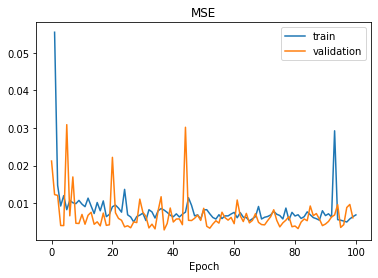

In [ ]:
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")

#### Test RNN and plot predicted vs. real values

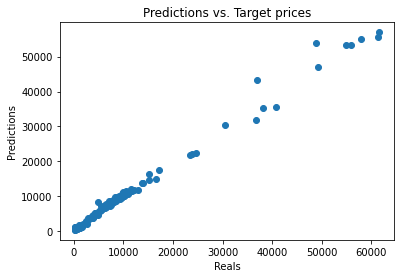

MAE: 628.5429894538341
MSE: 1184451.806555702


In [ ]:
real_values, predicted_values = test(rnn_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

### Train & Test LSTM

100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


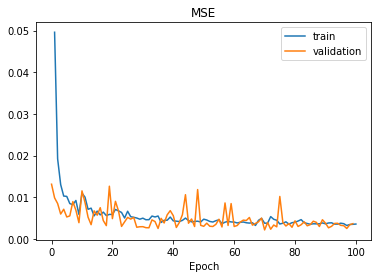

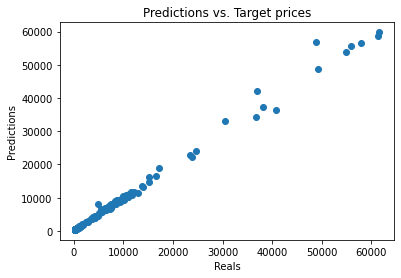

MAE: 362.81503568150697
MSE: 712785.8823894638


In [ ]:
lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, train_loader, val_loader, epochs_num, lstm_optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(lstm_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

### Train & Test GRU

100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


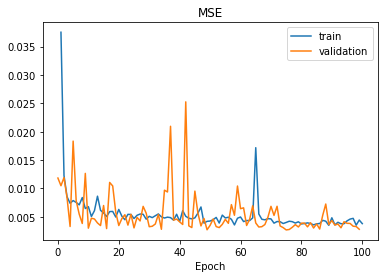

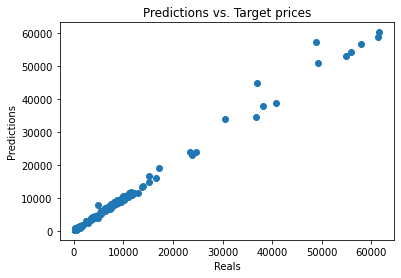

MAE: 383.8349741702259
MSE: 871977.026220915


In [ ]:
gru_model = GRU(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
gru_model.cuda()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(gru_model, train_loader, val_loader, epochs_num, gru_optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(gru_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

## Test different loss functions

### MSE loss function


100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


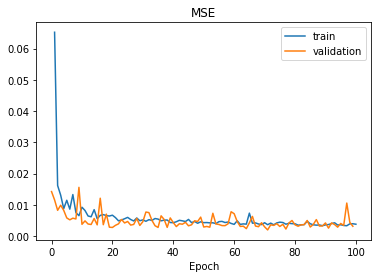

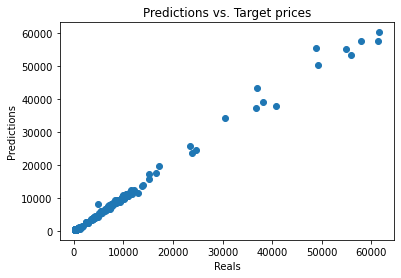

MAE: 355.11601573896604
MSE: 726030.4655282064


In [ ]:
lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, train_loader, val_loader, epochs_num, optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(lstm_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

### MAE loss function


100%|██████████| 100/100 [03:25<00:00,  2.06s/it]


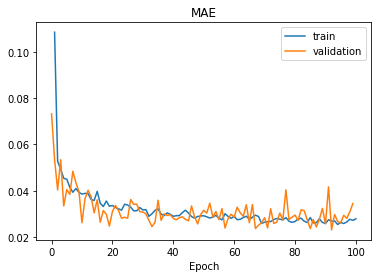

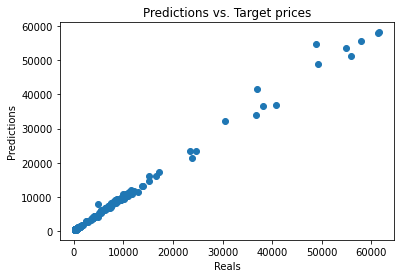

MAE: 400.6003307168415
MSE: 718052.1300879266


In [ ]:
lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
loss_function = nn.L1Loss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, train_loader, val_loader, epochs_num, optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MAE")
real_values, predicted_values = test(lstm_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

## Try different optimizers

### Adam optimizer


100%|██████████| 100/100 [03:24<00:00,  2.05s/it]


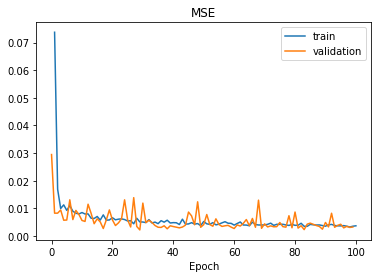

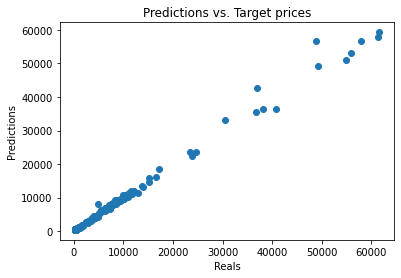

MAE: 388.2973291547467
MSE: 822431.1741875098


In [ ]:
lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, train_loader, val_loader, epochs_num, optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(lstm_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

### ADAgrad optimizer


100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


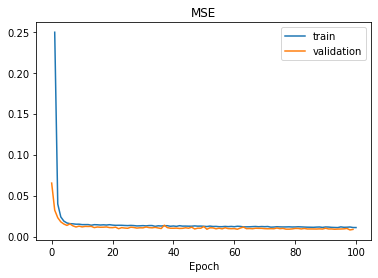

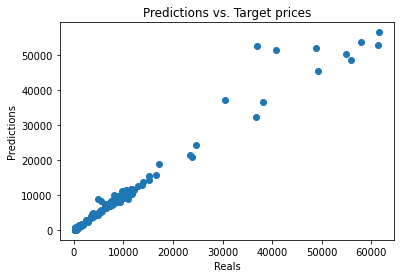

MAE: 641.8720129654121
MSE: 2968698.2248296835


In [ ]:
lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
optimizer = optim.Adagrad(lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, train_loader, val_loader, epochs_num, optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(lstm_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

### RMSprop optimizer


100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


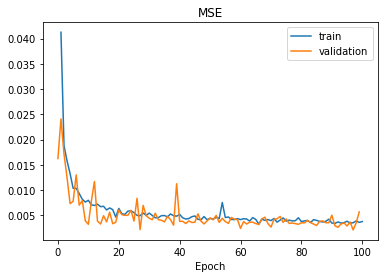

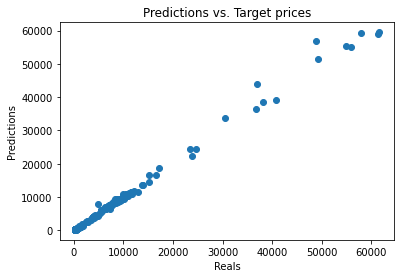

MAE: 322.7935333251953
MSE: 729309.3189438515


In [ ]:
lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
optimizer = optim.RMSprop(lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, train_loader, val_loader, epochs_num, optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(lstm_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

### SGD optimizer


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


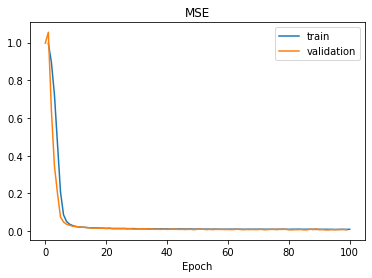

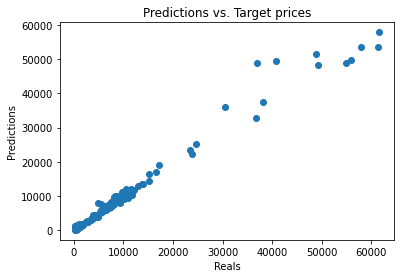

MAE: 619.0514009087907
MSE: 2104038.793558243


In [ ]:
lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
optimizer = optim.SGD(lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, train_loader, val_loader, epochs_num, optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(lstm_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

## Try removing dropout

### RNN Network without dropout


100%|██████████| 100/100 [02:37<00:00,  1.57s/it]


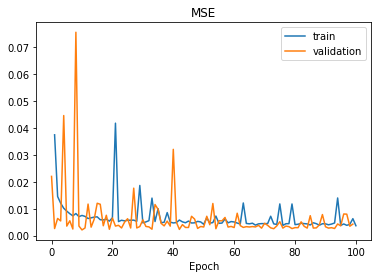

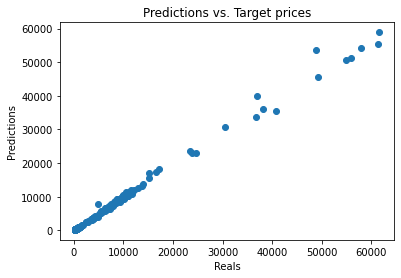

MAE: 391.57262050264615
MSE: 866552.6694797262


In [ ]:
dropout = 0

rnn_model = RNN(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
rnn_model.cuda()
optimizer = optim.RMSprop(rnn_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(rnn_model, train_loader, val_loader, epochs_num, optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(rnn_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

### RNN Network with dropout


100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


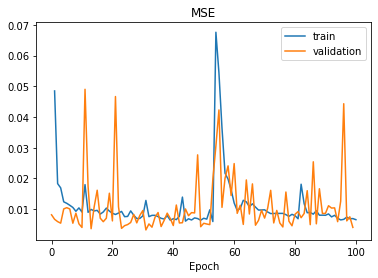

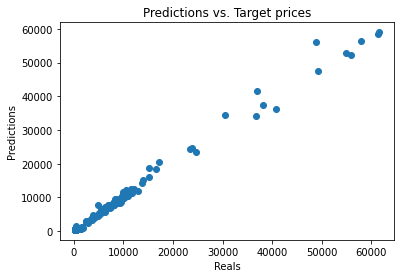

MAE: 493.6249462460087
MSE: 947054.7527428721


In [ ]:
dropout = 0.1

rnn_model = RNN(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
rnn_model.cuda()
optimizer = optim.RMSprop(rnn_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(rnn_model, train_loader, val_loader, epochs_num, optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(rnn_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

### LSTM Network


100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


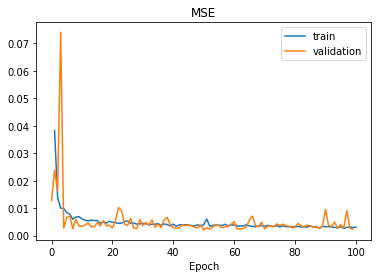

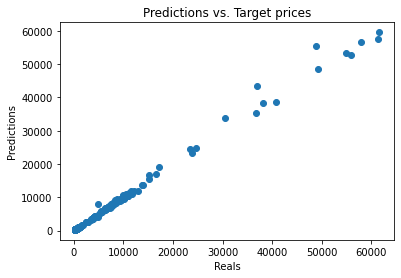

MAE: 283.45390269172646
MSE: 684272.9202275348


In [ ]:
dropout = 0

lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
lstm_optimizer = optim.RMSprop(lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, train_loader, val_loader, epochs_num, lstm_optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(lstm_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

### GRU Network

### GRU Network without dropout


100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


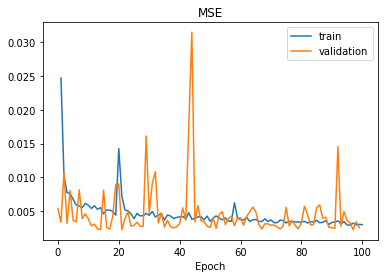

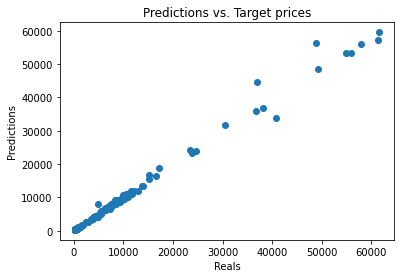

MAE: 317.9872828440053
MSE: 933055.2383456726


In [ ]:
dropout = 0

gru_model = GRU(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
gru_model.cuda()
gru_optimizer = optim.RMSprop(gru_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(gru_model, train_loader, val_loader, epochs_num, gru_optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(gru_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

### GRU Network with dropout


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


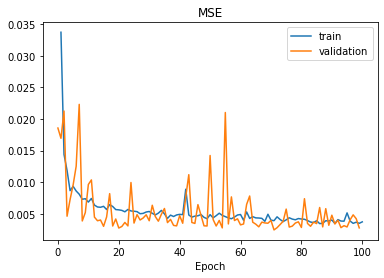

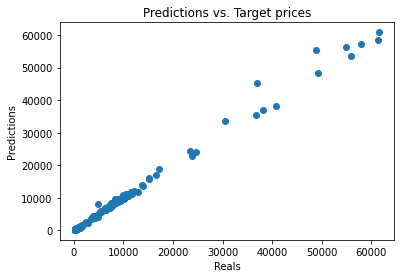

MAE: 345.1218870170879
MSE: 741372.6207814417


In [ ]:
dropout = 0.1

gru_model = GRU(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
gru_model.cuda()
gru_optimizer = optim.RMSprop(gru_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(gru_model, train_loader, val_loader, epochs_num, gru_optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(gru_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

## Regression with MLP

### Implement MLP Class

In [ ]:
class MLP(nn.Module):
  def __init__(self, layer_sizes, activation_function):
    super().__init__()
    self.layers = nn.ModuleList()
    for layer_number in range(len(layer_sizes)-1):
      self.layers.append(nn.Linear(layer_sizes[layer_number], layer_sizes[layer_number+1]))
    self.activation_function = activation_function
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, input):
    input = input.view(input.shape[0], -1)
    for layer_number in range(len(self.layers)-1):
      inactive_layer_output = self.layers[layer_number](input)
      activated_output = self.activation_function(inactive_layer_output)
      input = self.dropout(activated_output)
    
    output = self.layers[-1](input)
    return output.flatten()

### Test MLP Network


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same s

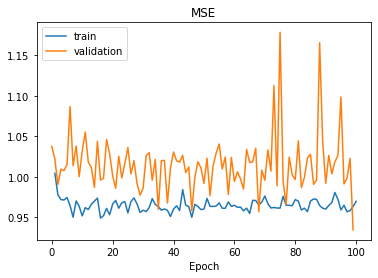

tensor([ 0.0543, -0.1641,  0.0502,  0.0502], device='cuda:0')
tensor([ 0.0543, -0.1641,  0.0502,  0.0502])
torch.Size([4])
tensor([-0.0429,  0.2041,  0.0098,  0.0157], device='cuda:0')
tensor([-0.0429,  0.2041,  0.0098,  0.0157])
torch.Size([4])
tensor([-0.1127,  0.0726, -0.1641,  0.0502], device='cuda:0')
tensor([-0.1127,  0.0726, -0.1641,  0.0502])
torch.Size([4])
tensor([-0.1641,  0.0051, -0.1641, -0.0475], device='cuda:0')
tensor([-0.1641,  0.0051, -0.1641, -0.0475])
torch.Size([4])
tensor([ 0.0502, -0.1221,  0.0041, -0.1225], device='cuda:0')
tensor([ 0.0502, -0.1221,  0.0041, -0.1225])
torch.Size([4])
tensor([ 0.0056, -0.1225, -0.0485,  0.0164], device='cuda:0')
tensor([ 0.0056, -0.1225, -0.0485,  0.0164])
torch.Size([4])
tensor([ 0.0238, -0.0804,  0.0502, -0.1641], device='cuda:0')
tensor([ 0.0238, -0.0804,  0.0502, -0.1641])
torch.Size([4])
tensor([-0.1641,  0.0502,  0.0053, -0.0035], device='cuda:0')
tensor([-0.1641,  0.0502,  0.0053, -0.0035])
torch.Size([4])
tensor([-0.1641,

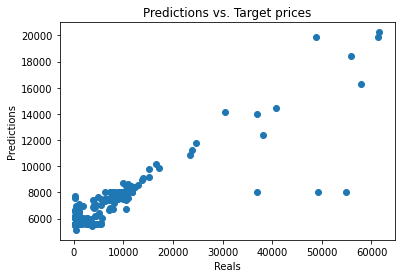

MAE: 4945.3458120892155
MSE: 75621927.14007343


In [ ]:
features = [x.flatten() for x in X_train]
feature_size = len(features[0])
layer_sizes = [feature_size, 32, 16, 8, 1]
activation_function = nn.ReLU()
dropout = 0.1
epochs_num = 100

mlp_model = MLP(layer_sizes, activation_function)
mlp_model.cuda()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.002)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(mlp_model, train_loader, val_loader, epochs_num, mlp_optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(mlp_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

## Test with all features

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)

100%|██████████| 100/100 [02:55<00:00,  1.76s/it]


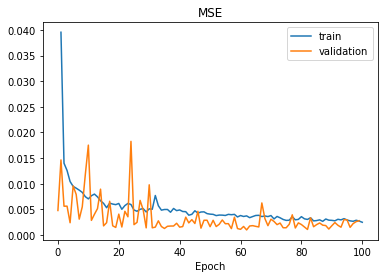

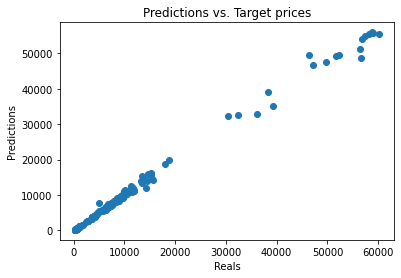

MAE: 416.25466051536966
MSE: 1049637.915139839


In [ ]:
def get_data_loaders_with_all_features():
  start = datetime.datetime(2014, 9, 20)
  end = datetime.datetime(2021, 5, 20)
  btc_data = pdr.get_data_yahoo(['BTC-USD'], start=start, end=end)
  btc_data.reset_index(inplace=True)
  btc_data.drop(['Date', 'Adj Close'], axis=1, inplace=True)
  labels = btc_data['Close'][1:]
  labels = labels.reset_index().drop(['index'], axis=1)
  btc_data.drop(btc_data.tail(1).index, inplace=True)
  btc_data = btc_data[["Close", "Open", "High", "Low", "Volume"]]
  scaler = StandardScaler()
  X = scaler.fit_transform(btc_data)
  y = scaler.fit_transform(labels)
  X_sequences = make_sequences(X)
  test_ratio = 0.1
  val_ratio = 0.1
  sequence_length = len(X_sequences[0])
  X_train, X_test, y_train, y_test = train_test_split(X_sequences, y[sequence_length-1:], test_size=test_ratio, shuffle=True)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=True)
  train_dataset = BTCTimeSeriesDataset(X_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
  test_dataset = BTCTimeSeriesDataset(X_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
  val_dataset = BTCTimeSeriesDataset(X_val, y_val)
  val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
  return train_loader, test_loader, val_loader, scaler


in_dimension = 5
hidden_dimension = 64
layer_count = 2
out_dimension = 1
dropout = 0
epochs_num = 100

all_train_loader, all_test_loader, all_val_loader, all_scaler = get_data_loaders_with_all_features()
lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
lstm_optimizer = optim.RMSprop(lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, all_train_loader, all_val_loader, epochs_num, lstm_optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(lstm_model, all_test_loader, all_scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

## Examine add hidden layer

### Without dropout


100%|██████████| 100/100 [04:45<00:00,  2.85s/it]


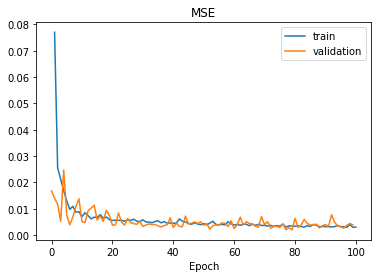

tensor([[ 0.1557],
        [ 0.0540],
        [ 0.4938],
        [-0.6293]], device='cuda:0')
tensor([[ 0.1557],
        [ 0.0540],
        [ 0.4938],
        [-0.6293]])
torch.Size([4, 1])
tensor([[-0.0697],
        [ 0.2899],
        [-0.6306],
        [-0.6288]], device='cuda:0')
tensor([[-0.0697],
        [ 0.2899],
        [-0.6306],
        [-0.6288]])
torch.Size([4, 1])
tensor([[-0.4279],
        [ 0.2697],
        [-0.5802],
        [-0.4411]], device='cuda:0')
tensor([[-0.4279],
        [ 0.2697],
        [-0.5802],
        [-0.4411]])
torch.Size([4, 1])
tensor([[-0.6293],
        [ 0.0874],
        [-0.6186],
        [ 0.2485]], device='cuda:0')
tensor([[-0.6293],
        [ 0.0874],
        [-0.6186],
        [ 0.2485]])
torch.Size([4, 1])
tensor([[-0.6315],
        [-0.5913],
        [ 0.3637],
        [ 0.2029]], device='cuda:0')
tensor([[-0.6315],
        [-0.5913],
        [ 0.3637],
        [ 0.2029]])
torch.Size([4, 1])
tensor([[-0.3210],
        [-0.6286],
        [-0.

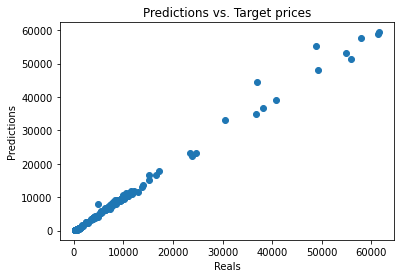

MAE: 367.1653496200119
MSE: 763673.7685463899


In [ ]:
in_dimension = 2
hidden_dimension = 64
layer_count = 4
out_dimension = 1
dropout = 0
epochs_num = 100

lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
lstm_optimizer = optim.RMSprop(lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, train_loader, val_loader, epochs_num, lstm_optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(lstm_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

### With dropout


100%|██████████| 100/100 [05:26<00:00,  3.27s/it]


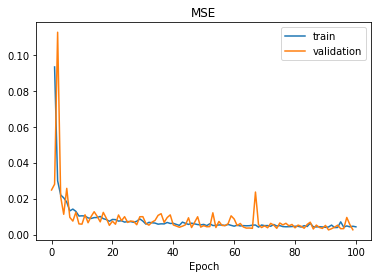

tensor([[-0.5821],
        [ 4.3383],
        [ 0.0852],
        [-0.0102]], device='cuda:0')
tensor([[-0.5821],
        [ 4.3383],
        [ 0.0852],
        [-0.0102]])
torch.Size([4, 1])
tensor([[-0.6088],
        [-0.6199],
        [ 0.3639],
        [ 0.0283]], device='cuda:0')
tensor([[-0.6088],
        [-0.6199],
        [ 0.3639],
        [ 0.0283]])
torch.Size([4, 1])
tensor([[-0.0077],
        [-0.6013],
        [ 0.0229],
        [-0.5878]], device='cuda:0')
tensor([[-0.0077],
        [-0.6013],
        [ 0.0229],
        [-0.5878]])
torch.Size([4, 1])
tensor([[-0.1525],
        [-0.6198],
        [-0.6160],
        [-0.6191]], device='cuda:0')
tensor([[-0.1525],
        [-0.6198],
        [-0.6160],
        [-0.6191]])
torch.Size([4, 1])
tensor([[-0.6125],
        [-0.6102],
        [-0.2720],
        [-0.4648]], device='cuda:0')
tensor([[-0.6125],
        [-0.6102],
        [-0.2720],
        [-0.4648]])
torch.Size([4, 1])
tensor([[ 0.0895],
        [-0.5746],
        [-0.

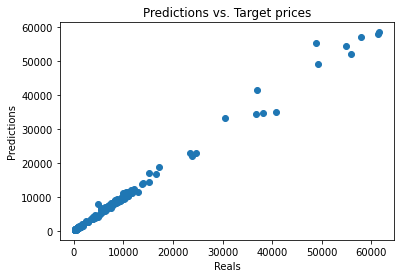

MAE: 399.8362636328733
MSE: 835083.9383313429


In [ ]:
in_dimension = 2
hidden_dimension = 64
layer_count = 4
out_dimension = 1
dropout = 0.1
epochs_num = 100

lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
lstm_optimizer = optim.RMSprop(lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, train_loader, val_loader, epochs_num, lstm_optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(lstm_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

## CNN-LSTM Network

### CNN-LSTM Class implementation 

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, in_dimension, hidden_dimension, layer_count, out_dimension, dropout):
        super(CNNLSTM, self).__init__()
        self.hidden_dimension = hidden_dimension
        self.layer_count = layer_count
        
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, padding=1, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.ReLU = nn.ReLU()

        self.lstm = nn.LSTM(in_dimension, hidden_dimension, layer_count, 
                            batch_first=True, dropout=dropout)
        self.fully_connected = nn.Linear(hidden_dimension, out_dimension)

    def forward(self, input):
        input = input.reshape((input.shape[0], 1, 28, 2))
        input = self.conv(input)
        input = self.ReLU(input)
        input = self.pool(input)
        input = input.reshape((input.shape[0], 28, 2))

        hidden = torch.zeros(self.layer_count, input.size(0), self.hidden_dimension).requires_grad_().cuda()
        cell_state = torch.zeros(self.layer_count, input.size(0), self.hidden_dimension).requires_grad_().cuda()
        out, _ = self.lstm(input, (hidden.detach(), cell_state.detach()))
        out = out[:, -1, :]
        out = self.fully_connected(out)
        return out

### Test CNN-LSTM



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:02<03:20,  2.03s/it]

  2%|▏         | 2/100 [00:04<03:17,  2.01s/it]

  3%|▎         | 3/100 [00:05<03:14,  2.00s/it]

  4%|▍         | 4/100 [00:08<03:14,  2.03s/it]

  5%|▌         | 5/100 [00:10<03:12,  2.03s/it]

  6%|▌         | 6/100 [00:12<03:10,  2.02s/it]

  7%|▋         | 7/100 [00:14<03:08,  2.02s/it]

  8%|▊         | 8/100 [00:16<03:05,  2.01s/it]

  9%|▉         | 9/100 [00:18<03:02,  2.01s/it]

 10%|█         | 10/100 [00:20<03:00,  2.00s/it]

 11%|█         | 11/100 [00:22<02:57,  2.00s/it]

 12%|█▏        | 12/100 [00:24<02:54,  1.99s/it]

 13%|█▎        | 13/100 [00:26<02:52,  1.99s/it]

 14%|█▍        | 14/100 [00:28<02:52,  2.00s/it]

 15%|█▌        | 15/100 [00:30<02:49,  2.00s/it]

 16%|█▌        | 16/100 [00:32<02:47,  2.00s/it]

 17%|█▋        | 17/100 [00:34<02:45,  2.00s/it]

 18%|█▊        | 18/100 [00:36<02:44,  2.00s/it]

 19%|█▉        | 19/100 [00:38<02:42,  2.00s/it]

 20%|██        |

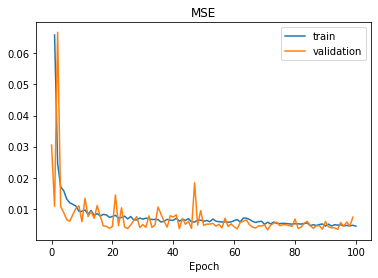

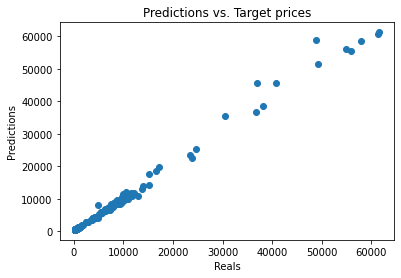

MAE: 437.55651697182554
MSE: 1226336.2782341596


In [ ]:
in_dimension = 2
hidden_dimension = 64
layer_count = 2
out_dimension = 1
dropout = 0
epochs_num = 100

cnn_lstm_model = CNNLSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
cnn_lstm_model.cuda()
cnn_lstm_optimizer = optim.RMSprop(cnn_lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(cnn_lstm_model, train_loader, val_loader, epochs_num, cnn_lstm_optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(cnn_lstm_model, test_loader, scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

## Use other transformations

### Normalization

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
100%|██████████| 100/100 [02:55<00:00,  1.76s/it]


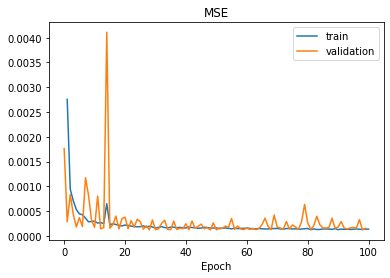

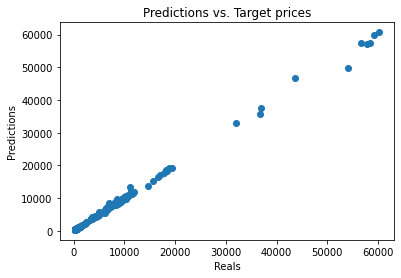

MAE: 229.1291039485462
MSE: 219976.87759556793


In [ ]:
def get_normalized_data_loaders():
  start = datetime.datetime(2014, 9, 20)
  end = datetime.datetime(2021, 5, 20)
  btc_data = pdr.get_data_yahoo(['BTC-USD'], start=start, end=end)
  btc_data.reset_index(inplace=True)
  btc_data.drop(['Date', 'Adj Close'], axis=1, inplace=True)
  labels = btc_data['Close'][1:]
  labels = labels.reset_index().drop(['index'], axis=1)
  btc_data.drop(btc_data.tail(1).index, inplace=True)
  btc_data = btc_data[["Close", "Open"]]
  scaler = MinMaxScaler()
  X = scaler.fit_transform(btc_data)
  y = scaler.fit_transform(labels)
  X_sequences = make_sequences(X)
  test_ratio = 0.1
  val_ratio = 0.1
  sequence_length = len(X_sequences[0])
  X_train, X_test, y_train, y_test = train_test_split(X_sequences, y[sequence_length-1:], test_size=test_ratio, shuffle=True)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=True)
  train_dataset = BTCTimeSeriesDataset(X_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
  test_dataset = BTCTimeSeriesDataset(X_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
  val_dataset = BTCTimeSeriesDataset(X_val, y_val)
  val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
  return train_loader, test_loader, val_loader, scaler


in_dimension = 2
hidden_dimension = 64
layer_count = 2
out_dimension = 1
dropout = 0
epochs_num = 100

normalized_train_loader, normalized_test_loader, normalized_val_loader, normalized_scaler = get_normalized_data_loaders()
lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
lstm_optimizer = optim.RMSprop(lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, normalized_train_loader, normalized_val_loader, epochs_num, lstm_optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(lstm_model, normalized_test_loader, normalized_scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

### Power transform


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


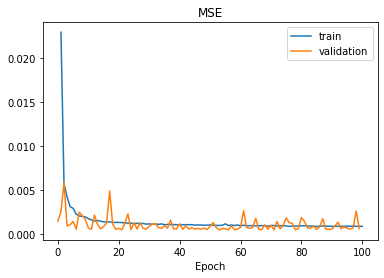

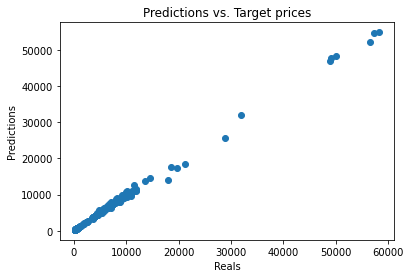

MAE: 248.3309571334615
MSE: 407061.7512797749


In [ ]:
def get_power_data_loaders():
  start = datetime.datetime(2014, 9, 20)
  end = datetime.datetime(2021, 5, 20)
  btc_data = pdr.get_data_yahoo(['BTC-USD'], start=start, end=end)
  btc_data.reset_index(inplace=True)
  btc_data.drop(['Date', 'Adj Close'], axis=1, inplace=True)
  labels = btc_data['Close'][1:]
  labels = labels.reset_index().drop(['index'], axis=1)
  btc_data.drop(btc_data.tail(1).index, inplace=True)
  btc_data = btc_data[["Close", "Open"]]
  scaler = PowerTransformer(method='box-cox')
  X = scaler.fit_transform(btc_data)
  y = scaler.fit_transform(labels)
  X_sequences = make_sequences(X)
  test_ratio = 0.1
  val_ratio = 0.1
  sequence_length = len(X_sequences[0])
  X_train, X_test, y_train, y_test = train_test_split(X_sequences, y[sequence_length-1:], test_size=test_ratio, shuffle=True)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=True)
  train_dataset = BTCTimeSeriesDataset(X_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
  test_dataset = BTCTimeSeriesDataset(X_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
  val_dataset = BTCTimeSeriesDataset(X_val, y_val)
  val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
  return train_loader, test_loader, val_loader, scaler


in_dimension = 2
hidden_dimension = 64
layer_count = 2
out_dimension = 1
dropout = 0
epochs_num = 100

power_train_loader, power_test_loader, power_val_loader, power_scaler = get_power_data_loaders()
lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
lstm_optimizer = optim.RMSprop(lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, power_train_loader, power_val_loader, epochs_num, lstm_optimizer, loss_function)
plot_losses(epochs_train_loss, epochs_validate_loss, epochs_num, "MSE")
real_values, predicted_values = test(lstm_model, power_test_loader, power_scaler)
real_values = [value[0] for value in real_values]
predicted_values = [value[0] for value in predicted_values]
plot_pred_vs_target(real_values, predicted_values)
print(f"MAE: {mean_absolute_error(real_values, predicted_values)}")
print(f"MSE: {mean_squared_error(real_values, predicted_values)}")

## Predict 7 consecutive days

In [ ]:
def get_single_normalized_data_loaders():
  start = datetime.datetime(2014, 9, 20)
  end = datetime.datetime(2021, 5, 20)
  btc_data = pdr.get_data_yahoo(['BTC-USD'], start=start, end=end)
  btc_data.reset_index(inplace=True)
  btc_data.drop(['Date', 'Adj Close'], axis=1, inplace=True)
  labels = btc_data['Close'][1:]
  labels = labels.reset_index().drop(['index'], axis=1)
  btc_data.drop(btc_data.tail(1).index, inplace=True)
  btc_data = btc_data[["Close"]]
  scaler = MinMaxScaler()
  X = scaler.fit_transform(btc_data)
  y = scaler.fit_transform(labels)
  X_sequences = make_sequences(X)
  test_ratio = 0.1
  val_ratio = 0.1
  sequence_length = len(X_sequences[0])
  X_train, X_test, y_train, y_test = train_test_split(X_sequences, y[sequence_length-1:], test_size=test_ratio, shuffle=True)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=True)
  train_dataset = BTCTimeSeriesDataset(X_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
  test_dataset = BTCTimeSeriesDataset(X_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
  val_dataset = BTCTimeSeriesDataset(X_val, y_val)
  val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
  return train_loader, test_loader, val_loader, scaler


in_dimension = 1
hidden_dimension = 64
layer_count = 2
out_dimension = 1
dropout = 0
epochs_num = 100

normalized_train_loader, normalized_test_loader, normalized_val_loader, normalized_scaler = get_single_normalized_data_loaders()
lstm_model = LSTM(in_dimension, hidden_dimension, layer_count, out_dimension, dropout)
lstm_model.cuda()
lstm_optimizer = optim.RMSprop(lstm_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
epochs_train_loss, epochs_validate_loss = train_and_validate(lstm_model, normalized_train_loader, normalized_val_loader, epochs_num, lstm_optimizer, loss_function)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


In [ ]:
sequence_length = 28
predicted_values = []
feature = 0

for features, _ in normalized_test_loader:
  feature = features
  break

with torch.no_grad():
  for index in range(sequence_length + 7):
    feature = feature.cuda()
    output = lstm_model(feature.float())
    predicted_value = normalized_scaler.inverse_transform(output.cpu())[0]
    feature = feature.cpu().numpy()
    scaled_predicted_value = normalized_scaler.transform([predicted_value])
    deleted_feature = np.array([[x] for x in np.delete(feature[0], [0])])
    appended_feature = np.append(deleted_feature, [scaled_predicted_value])
    feature[0] = np.array([[x] for x in appended_feature])
    feature = torch.from_numpy(feature)

    if index >= sequence_length:
      predicted_values.append(predicted_value)

In [ ]:
predicted_values

[array([59110.43180576]),
 array([58675.23365846]),
 array([58334.32215226]),
 array([58073.7316918]),
 array([57885.83781693]),
 array([57767.27368681]),
 array([57716.96734763])]